In [ ]:
import os
import time
from datetime import datetime, timedelta
import subprocess
import shutil
import psutil
import json
import sys
from glob import glob

from pathlib import Path


In [2]:
# This is where I noticed w1 w2 running long
# os.chdir("/home/haman/layers56/OptLSV1M/20250701-111155_Optimization")

# This is without w1 w2
# os.chdir("/home/haman/layers56/LSV1M_split_full/20250704-222215_Optimization")

# This is test of w1 w2
os.chdir("/home/haman/layers56/LSV1M_split_ee/20250707-143705_Optimization")


In [3]:
# Parse the slurm job IDs from the slurm output files
slurm_ids = [(x.split("-")[1]).split(".")[0] for x in glob("slurm-*.out")]

elapsedtimes = []
nodes = []
states = []
for slurm_id in slurm_ids:
    slurm_status = (str(subprocess.run(['sacct', '-j', slurm_id, '--format=JobID,JobName,State,Elapsed,Start,End,ExitCode,NodeList', '--noheader'],
                                            stdout=subprocess.PIPE, timeout=20).stdout.decode('utf-8'))).split("\n")
    for line in slurm_status:
        if "sbatch" in line:
            slurm_status = line.split()
            break
    else:
        raise ValueError(f"No sbatch job found in the slurm status output, for job {slurm_id}.")
    h,ms,s = map(int, slurm_status[3].split(":"))
    elapsed = timedelta(hours=h, minutes=ms, seconds=s)
    elapsedtimes.append(elapsed)
    nodes.append(slurm_status[7])
    states.append(slurm_status[2])

# Print the jobs sorted by elapsed time
w12 = []
w_others = []

for el, id, node, state in  sorted([(el, id, node, state) for el, id, node, state in zip(elapsedtimes, slurm_ids, nodes, states)], reverse=True):
    if node in {"w1", "w2"}:
        w12.append(el)
        # continue
    else:
        w_others.append(el)
    print(f"Job {id}, node {node}, state {state} has been running for {el}.")
    


Job 1702164, node w1, state COMPLETED has been running for 14:31:32.
Job 1702445, node w1, state RUNNING has been running for 4:16:28.
Job 1702166, node w2, state COMPLETED has been running for 2:35:20.
Job 1702446, node w1, state COMPLETED has been running for 2:03:25.
Job 1702447, node w2, state COMPLETED has been running for 1:31:11.
Job 1702448, node w2, state COMPLETED has been running for 1:29:41.
Job 1702165, node w1, state COMPLETED has been running for 1:06:49.
Job 1702167, node w2, state COMPLETED has been running for 1:01:33.
Job 1702130, node w2, state COMPLETED has been running for 0:47:01.
Job 1702128, node w1, state COMPLETED has been running for 0:45:50.
Job 1702129, node w2, state COMPLETED has been running for 0:30:21.
Job 1702131, node w2, state COMPLETED has been running for 0:29:50.


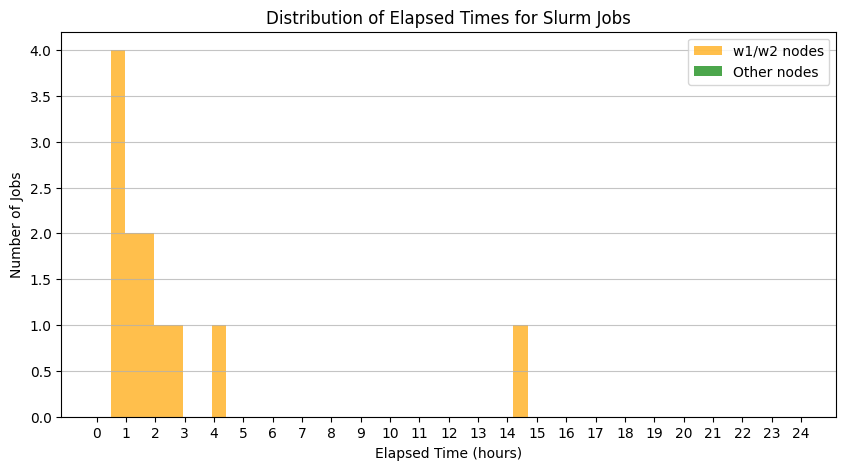

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))

elapsed_float = [et.total_seconds()/3600 for et in elapsedtimes]

w12_float = [et.total_seconds()/3600 for et in w12]
w_others_float = [et.total_seconds()/3600 for et in w_others]

# plt.hist(elapsed_float, bins=20, color='blue', alpha=0.7)
bins = np.linspace(0,24, 50)

plt.hist(w12_float, bins=bins, color='orange', alpha=0.7, label='w1/w2 nodes')
plt.hist(w_others_float, bins=bins, color='green', alpha=0.7, label='Other nodes')

plt.legend()

plt.xticks(np.arange(0, 25, 1))

plt.title('Distribution of Elapsed Times for Slurm Jobs')
plt.xlabel('Elapsed Time (hours)')
plt.ylabel('Number of Jobs')
plt.grid(axis='y', alpha=0.75)

# sorted(elapsedtimes, reverse=True)